# Lipschitz constant of a convolutional layer in neural network

It was observed, that small perturbation in Neural Network input could lead to significant errors, i.e. misclassifications.

![https://escholarship.org/content/qt3k2780bg/qt3k2780bg_noSplash_e0803cb722032c480ec3468d84e60e2a.pdf?t=qqf3iz](https://fmin.xyz/docs/applications/adv_attack.png)

Lipschitz constant bounds the magnitude of the output of a function, so it cannot change drastically with a slight change in the input

$$
\|NN(image) - NN(image+\varepsilon)\| \leq L\|\varepsilon\|
$$

In this notebook we will try to estimate Lipschitz constant of some convolutional layer of a Neural Network.

## Power method for the singular value estimation

## Download pretrained model

In [274]:
import torch
import random
import copy
import numpy as np
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

def fix_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(0)
    np.random.seed(0)


# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

Using cache found in /Users/bratishka/.cache/torch/hub/pytorch_vision_v0.10.0


In [389]:
@torch.no_grad()
def power_method_for_nn_layer(layer, n_iterations=10):
    sigmas = []
    # print(f"Layer norm {torch.norm(list(layer.parameters())[0])}")
    x = copy.deepcopy(input_batch)*1.0
    # print(torch.norm(x))
    # Create custom layer from pretrained layer:
    conv_layer = torch.nn.Conv2d(3, 64, 7, padding=3)
    conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)

    conv_layer.weight.data = copy.deepcopy(list(layer.parameters())[0].data)
    conv_layer.bias.data.zero_()

    conv_t_layer.weight.data = copy.deepcopy(list(layer.parameters())[0].data)
    conv_t_layer.bias.data.zero_()

    # print(f"W norm {torch.norm(list(conv_layer.parameters())[0])}")
    # print(f"WT norm {torch.norm(list(conv_t_layer.parameters())[0])}")
    # print(f"x norm {torch.norm(x)}")

    for i in range(n_iterations):
        
        # y =   W@x computation
        # print(f"✅ {list(conv_layer.parameters())[0][0][0][0][0]}")

        y = conv_layer(x)
        # print(f"y norm {torch.norm(y)}")

        # x = W.T@y computation
        x = conv_t_layer(y)
        x_norm = torch.norm(x)

        # Normalization
        x = x/x_norm
       
        # sigma computation
        sigma = torch.norm(conv_layer(x))/torch.norm(x)
        sigmas.append(sigma)
    
    return sigmas

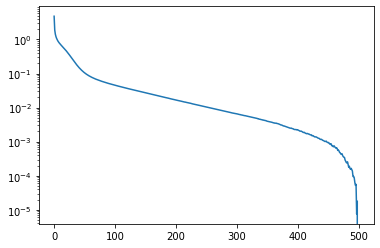

In [396]:
from matplotlib import pyplot as plt
sigmas = power_method_for_nn_layer(model.conv1, 500)
plt.semilogy([sigmas[-1] - sigma for sigma in sigmas])

In [397]:
sigmas[-10:]

[tensor(15.8986),
 tensor(15.8986),
 tensor(15.8986),
 tensor(15.8986),
 tensor(15.8986),
 tensor(15.8986),
 tensor(15.8987),
 tensor(15.8987),
 tensor(15.8987),
 tensor(15.8987)]

In [375]:
@torch.no_grad()
def power_method_for_nn_tensor(tensor, n_iterations=10):
    # fix_seed()
    print(f"Layer norm {torch.norm(tensor)}")
    x = copy.deepcopy(input_batch)*1.0
    # print(torch.norm(x))
    # Create custom layer from pretrained layer:
    conv_layer = torch.nn.Conv2d(3, 64, 7, padding=3)
    conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)

    # Initialization done right:
    for p_new, p_new_t in zip(conv_layer.parameters(),
                                conv_t_layer.parameters()):
        p_c = copy.deepcopy(tensor)
        print(p_new.shape)
        p_new.data.copy_(p_c)
        p_c_t = copy.deepcopy(tensor)
        p_new_t.data.copy_(p_c_t)

    print(f"W norm {torch.norm(list(conv_layer.parameters())[0])}")
    print(f"WT norm {torch.norm(list(conv_t_layer.parameters())[0])}")
    print(f"x norm {torch.norm(x)}")

    for i in range(n_iterations):
        
        # y =   W@x computation
        print(f"✅ {list(conv_layer.parameters())[0][0][0][0][0]}")

        y = conv_layer(x)
        print(f"y norm {torch.norm(y)}")
        y_norm = torch.norm(y)

        # x = W.T@y computation
        x = conv_t_layer(y)
        x_norm = torch.norm(x)

        # Normalization
        x = x/x_norm
       
        # sigma computation
        sigma = torch.norm(conv_layer(x))/torch.norm(x)
        print(sigma)
    
    return sigma

In [352]:
tensor = list(model.conv1.parameters())[0]
print(tensor.shape)
sigma = power_method_for_nn_tensor(tensor, n_iterations=10)

torch.Size([64, 3, 7, 7])
Layer norm 12.57936954498291
torch.Size([64, 3, 7, 7])
torch.Size([64])


RuntimeError: The size of tensor a (64) must match the size of tensor b (7) at non-singleton dimension 3

In [357]:
for par in conv1_custom.parameters():
    print(f"🦄 {par}")

🦄 Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-0

## Fourier will help

In [400]:
kernel = torch.permute(model.conv1.weight.data, [2, 3, 0, 1])
input_shape = input_batch.shape
s = np.fft.fft2(kernel, (224, 224), axes=[0, 1])
s = np.linalg.svd(s, compute_uv=False)

In [401]:
np.max(s)

15.916427973378767

In [386]:
input_shape

torch.Size([1, 3, 224, 224])

In [374]:
conv_layer = torch.nn.Conv2d(3, 64, 7, padding=3)
conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)

print(conv_layer.weight.shape)
print(conv_t_layer.weight.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])


In [243]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [181]:
# With square kernels and equal stride
fix_seed()
m = nn.Conv2d(16, 33, 3)
# input = torch.randn(20, 16, 50, 100)
output = m(input)
print(torch.norm(output))

tensor(1013.8447, grad_fn=<CopyBackwards>)


In [98]:
print(sigma)

tensor(0.2804, grad_fn=<DivBackward0>)


In [47]:
list(model.conv1.parameters())[0].shape

torch.Size([64, 3, 7, 7])

In [51]:
conv1_output = model.conv1(input_batch)
print(conv1_output.shape)
conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)
conv_t_layer(conv1_output).shape


torch.Size([1, 64, 112, 112])


torch.Size([1, 3, 112, 112])

In [92]:
conv1_custom = torch.nn.Conv2d(3, 64, 7, stride=2, padding=3)
conv1_custom_output = conv1_custom(input_batch)
conv1_custom_output.shape

torch.Size([1, 64, 112, 112])

In [91]:
list(model.conv1.parameters())[0].shape

torch.Size([64, 3, 7, 7])

In [89]:
conv1_custom = torch.nn.Conv2d(3, 64, 7, stride=2, padding=3)
list(conv1_custom.parameters())[0].shape

torch.Size([64, 3, 7, 7])

In [90]:
conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)
list(conv_t_layer.parameters())[0].shape

torch.Size([64, 3, 7, 7])

In [93]:
conv_t_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)
conv_t_layer(conv1_output).shape
for p_new, p_new_t, p in zip(conv1_custom.parameters(),
                                conv_t_layer.parameters(),
                                model.conv1.parameters()):
        p_new.data.copy_(p)
        p_new_t.data.copy_(p)

In [73]:
p_new_t.data.shape

torch.Size([64, 3, 7, 7])

In [61]:
torch.norm(list(model.conv1.parameters())[0])

tensor(12.5794, grad_fn=<CopyBackwards>)

In [62]:
torch.norm(list(conv1_custom.parameters())[0])

tensor(12.5794, grad_fn=<CopyBackwards>)

In [19]:
import torch
import torch.nn as nn
# With square kernels and equal stride
m = nn.ConvTranspose2d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
input = torch.randn(20, 16, 50, 100)
output = m(input)
# exact output size can be also specified as an argument
input = torch.randn(1, 16, 12, 12)
print(input.size())
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
h = downsample(input)
print(h.size())
output = upsample(h, output_size=input.size())
print(output.size())

torch.Size([1, 16, 12, 12])
torch.Size([1, 16, 6, 6])
torch.Size([1, 16, 12, 12])
